<a href="https://colab.research.google.com/github/tanisha1112/AnomalyDetectionCVPR2018/blob/master/iGem_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import time
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models
import numpy as np
from torch import topk
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import functional as F

%matplotlib inline

In [ ]:
#image normalization
transform = transforms.Compose([
    # resize
    transforms.Resize(32),
    # center-crop
    transforms.CenterCrop(32),
    # to-tensor
    transforms.ToTensor(),
    # normalize
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
def get_relevant_indices(dataset, classes, target_classes):

    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 10
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
    

In [ ]:
def get_data_loader(target_classes, batch_size,split_percent):
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    
    # Split into train and validation
    
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * split_percent)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               **kwargs, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              **kwargs, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

In [ ]:
target_classes=["cat", "dog"]
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes, 
    batch_size=batch_size,
    split_percent = 0.9)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


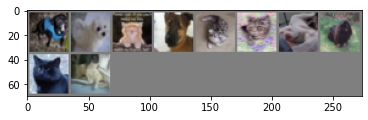

dog   dog   cat   dog   cat   cat   dog   dog   cat   cat  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
images.shape

torch.Size([10, 3, 32, 32])

In [ ]:
catTestCount = 0
dogTestCount = 0

catTrainCount = 0
dogTrainCount = 0

catValCount = 0
dogValCount = 0

for images, labels in train_loader:
  for label in labels:
    if label == 3:
      catTrainCount += 1
    elif label == 5:
      dogTrainCount += 1

for images, labels in test_loader:
  for label in labels:
    if label == 3:
      catTestCount += 1
    elif label == 5:
      dogTestCount += 1

for images, labels in val_loader:
  for label in labels:
    if label == 3:
      catValCount += 1
    elif label == 5:
      dogValCount += 1
    
print("Cat Train Count:", str(catTrainCount))
print("Dog Train Count:", str(dogTrainCount))

print("Cat Test Count:", str(catTestCount))
print("Dog Test Count:", str(dogTestCount))

print("Cat Validation Count:", str(catValCount))
print("Dog Validation Count:", str(dogValCount))

Cat Train Count: 4503
Dog Train Count: 4497
Cat Test Count: 1000
Dog Test Count: 1000
Cat Validation Count: 497
Dog Validation Count: 503


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epochs = 4
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

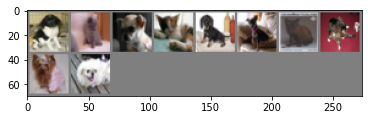

GroundTruth:  dog   cat   dog   cat   dog   dog   cat   cat   dog   dog  


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

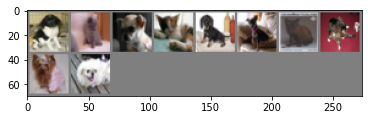

Predicted:  cat   cat   dog   cat   dog   cat   cat   cat   cat   dog  


In [ ]:
_, predicted = torch.max(outputs, 1)
imshow(torchvision.utils.make_grid(images))

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

In [ ]:
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    # calculate outputs by running images through the network
    outputs = net(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100 * correct // total} %')

Accuracy of the network on the 1000 test images: 64 %


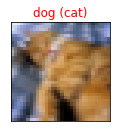

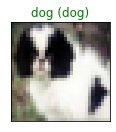

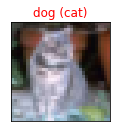

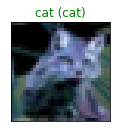

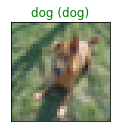

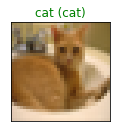

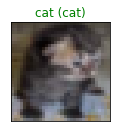

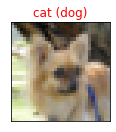

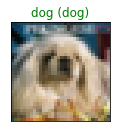

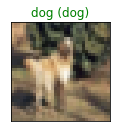

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()
train_on_gpu = torch.cuda.is_available()

def im_show(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = net(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())


for idx in np.arange(10):
  # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(50, 4))
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    im_show(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [ ]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
net._modules

OrderedDict([('conv1', Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))),
             ('pool',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('conv2', Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))),
             ('fc1', Linear(in_features=400, out_features=120, bias=True)),
             ('fc2', Linear(in_features=120, out_features=84, bias=True)),
             ('fc3', Linear(in_features=84, out_features=10, bias=True))])

In [ ]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
net._modules.get('conv2').register_forward_hook(hook_feature)

In [ ]:
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [81]:
weight_softmax.shape

(10, 84)

In [ ]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
import cv2
def show_cam(CAMs, width, height, orig_image, class_idx, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.5 + orig_image * 0.5
        # put class label text on the result
        cv2.putText(result, str(int(class_idx[i])), (20, 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow('CAM', result/255.)
        cv2.waitKey(0)
        cv2.imwrite(f"outputs/CAM_{save_name}.jpg", result)

In [77]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
output = net(images)
# convert output probabilities to predicted class

_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy())
# for i in range(len(images)):
#   im_show(images[i])


In [83]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [85]:
weight_softmax[3]

array([-0.10158413, -0.06738006, -0.02588747,  0.03757304,  0.38563535,
        0.2525664 ,  0.38612464, -0.0335115 , -0.00302246,  0.02676245,
        0.06826252,  0.02224741,  0.02316773,  0.14518578,  0.06626869,
        0.36195952,  0.1347009 ,  0.05383797,  0.08561807, -0.07331159,
        0.06291384, -0.06727   ,  0.06436145,  0.27050713,  0.12557244,
        0.06275872, -0.03378901, -0.01208595,  0.15387137,  0.08706634,
        0.08340935, -0.08573654,  0.01190105, -0.00563058,  0.03972555,
       -0.0640206 ,  0.06200484,  0.08028875,  0.09620609, -0.00889731,
        0.08357168, -0.08861147,  0.0400191 , -0.06687945, -0.03055201,
       -0.03645731,  0.06729261, -0.01125913,  0.19070627, -0.00402535,
       -0.03414723,  0.15343004,  0.07180087,  0.02931007,  0.09270281,
       -0.00200002,  0.18708788,  0.01313974, -0.01002954,  0.05092524,
        0.0957173 , -0.00572002,  0.18737887,  0.00947431,  0.0302459 ,
        0.052129  , -0.03299016, -0.05690552, -0.04669517,  0.05